# Applied Data Science

## Data Wrangling

### Niall Twomey

To contact, please email `<firstname>.<lastname>@bristol.ac.uk`

This notebook considers the [CASAS](http://casas.wsu.edu) dataset. This is a dataset collected in a smart environment. As participants interact with the house, sensors record their interactions. There are a number of different sensor types including motion, door contact, light, temperature, water flow, etc. (see sensorlayout2.png)

This notebook goes through a number of common issues in data science when working with real data. Namely, several issues relating to dates, sensor values, etc. This are dealt with consistently using the functionality provided by the `pandas` library. 

The objective is to fix all errors (if we can), and then to convert the timeseries data to a form that would be recognisable by a machine learning algorithm. I have attempted to comment my code where possible to explain my thought processes. At several points in this script I could have taken shortcuts, but I also attempted to forgo brevity for clarity. 

For more detail on this dataset, see 

1. Cook, Diane J., and Maureen Schmitter-Edgecombe. "[Assessing the quality of activities in a smart environment.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2759863/)" *Methods of information in medicine* 48.5 (2009): 480.

2. Twomey, Niall, Tom Diethe, and Peter Flach. "[On the need for structure modelling in sequence prediction.](http://link.springer.com/article/10.1007/s10994-016-5571-y)" *Machine Learning* 104.2-3 (2016): 291-314.

3. Twomey, Niall, et al. "[Unsupervised learning of sensor topologies for improving activity recognition in smart environments.](https://www.researchgate.net/publication/312029609)" *Neurocomputing* (2016).

4. Diethe, Tom, Niall Twomey, and Peter Flach. "[Bayesian modelling of the temporal aspects of smart home activity with circular statistics.](http://link.springer.com/chapter/10.1007/978-3-319-23525-7_17)" *Joint European Conference on Machine Learning and Knowledge Discovery in Databases*. Springer International Publishing, 2015.

5. Twomey, Niall, and Peter Flach. "[Context modulation of sensor data applied to activity recognition in smart homes.](https://www.researchgate.net/publication/279931064)" *Workshop on Learning over Multiple Contexts, European Conference on Machine Learning* (ECML’14). 2014.

In [1]:
## from __future__ import print_function  # uncomment if using python 2
from os.path import join 

import pandas as pd
import numpy as np
from datetime import datetime

%matplotlib inline

Set up various parameters and variables that will be used in this script

In [2]:
url = 'http://casas.wsu.edu/datasets/twor.2009.zip'
zipfile = url.split('/')[-1]
dirname = '.'.join(zipfile.split('.')[:2])
filename = join(dirname, 'data')

print('     url: {}'.format(url))
print(' zipfile: {}'.format(zipfile))
print(' dirname: {}'.format(dirname))
print('filename: {}'.format(filename))

     url: http://casas.wsu.edu/datasets/twor.2009.zip
 zipfile: twor.2009.zip
 dirname: twor.2009
filename: twor.2009/data


Download the dataset, and unzip it using the following commands in shell

```shell
wget http://casas.wsu.edu/datasets/twor.2009.zip
unzip twor.2009.zip
```

or directly in python

```python
from subprocess import call
call(('wget', url));
call(('unzip', zipfile);
```

In [3]:
#from subprocess import call
#call(('wget', url));
#call(('unzip', zipfile));

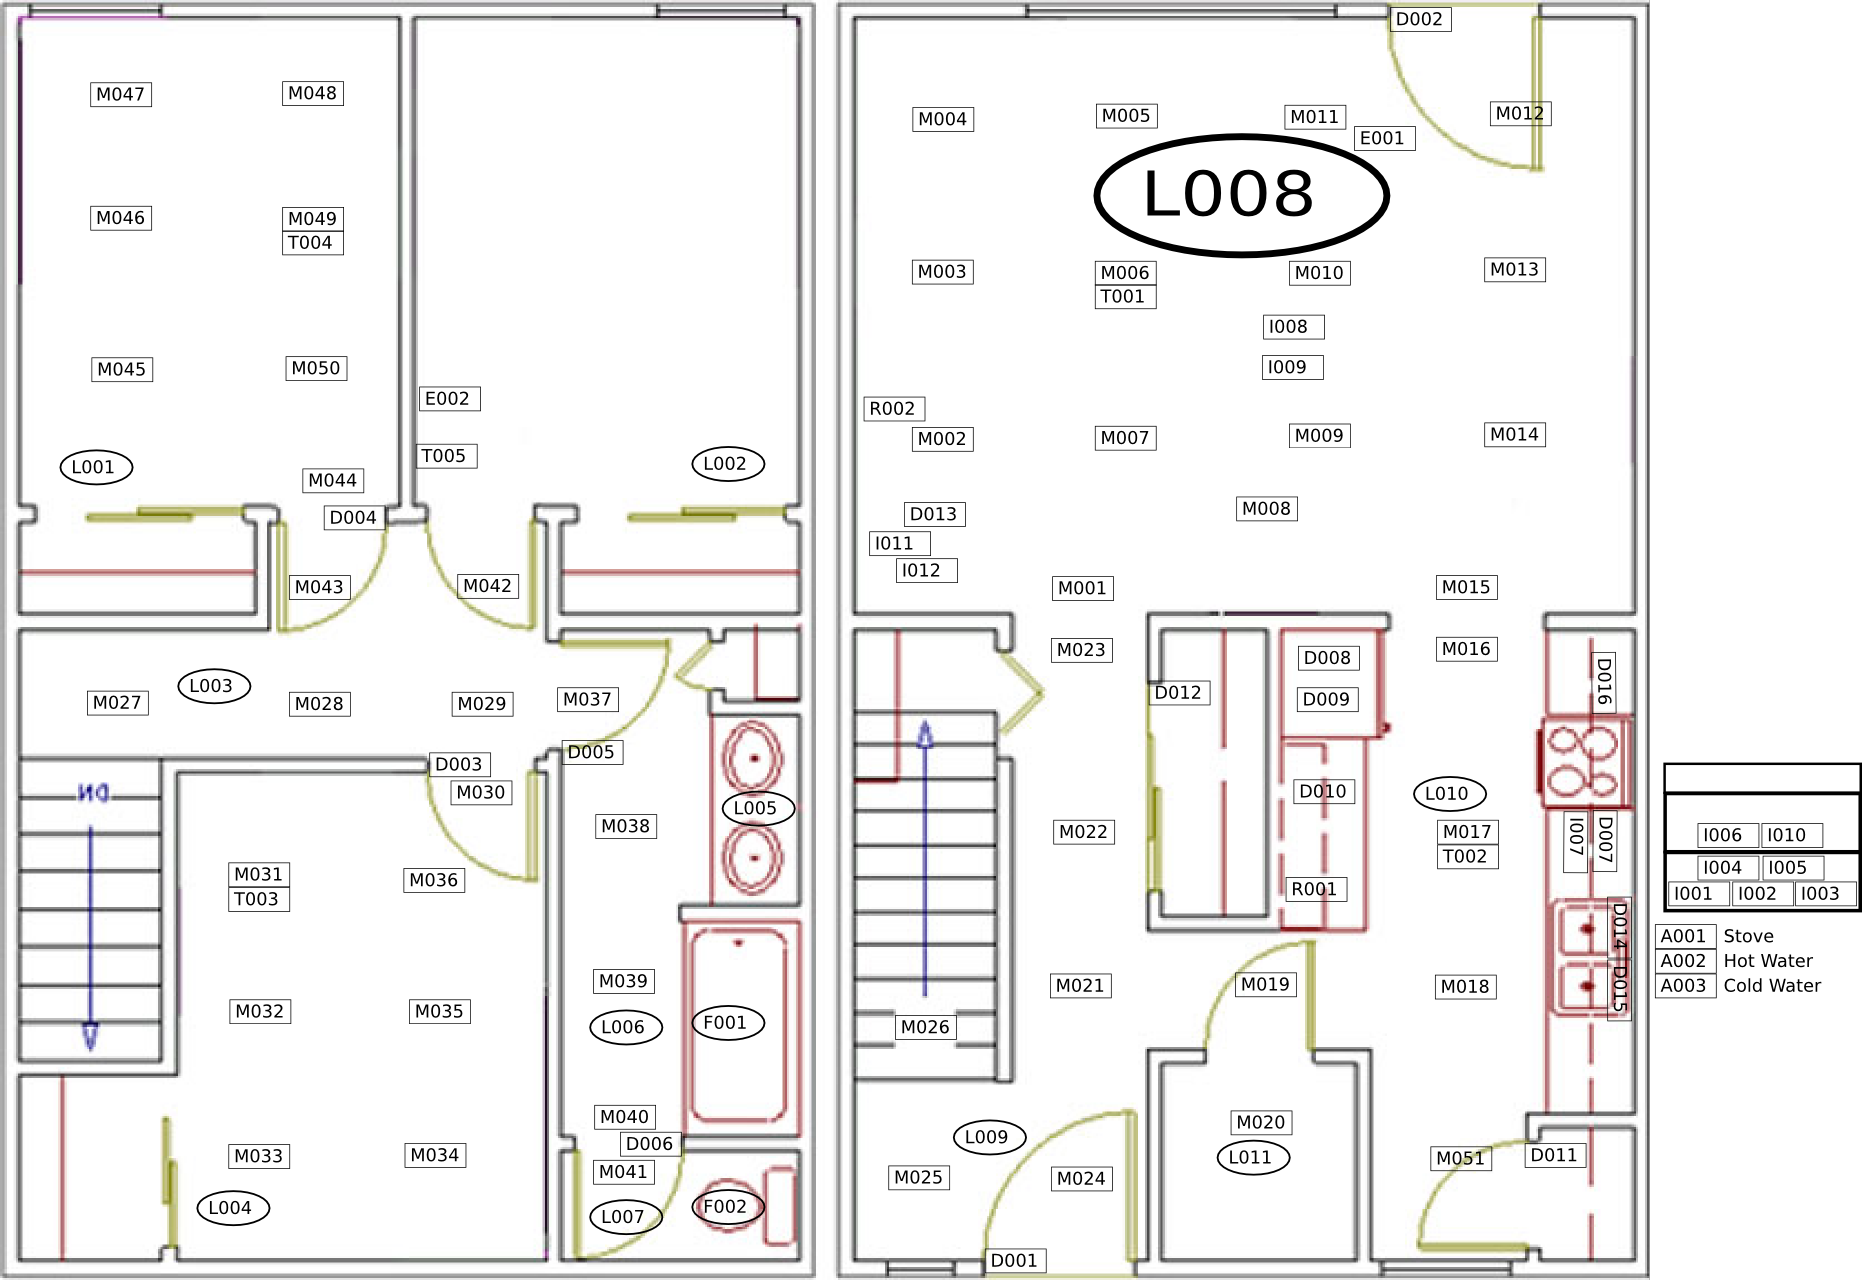

In [4]:
from IPython.display import Image
Image("twor.2009/sensorlayout2.png")

In [5]:
column_headings = ('date', 'time', 'sensor', 'value', 'annotation', 'state')

df = pd.read_csv(
    filename, 
    delim_whitespace=True,  # Note, the file is delimited by both space and tab characters
    names=column_headings
)

df.head()

,date,time,sensor,value,annotation,state
0,2009-02-02,07:15:16.575809,M35,ON,R1_Bed_to_Toilet,begin
1,2009-02-02,07:15:21.408519,AD1-A,2.82231,NaN,NaN
2,2009-02-02,07:15:22.532789,M35,OFF,NaN,NaN
3,2009-02-02,07:15:23.345479,M35,ON,NaN,NaN
4,2009-02-02,07:15:27.529299,AD1-A,2.79926,NaN,NaN


In [6]:
df.columns
#df.sensor

Index(['date', 'time', 'sensor', 'value', 'annotation', 'state'], dtype='object')

In [7]:
df.dtypes

date          object
time          object
sensor        object
value         object
annotation    object
state         object
dtype: object

In [8]:
df.time[0]

'07:15:16.575809'

In [9]:
df['datetime'] = pd.to_datetime(df[['date', 'time']].apply(lambda row: ' '.join(row), axis=1))

ValueError: year 22009 is out of range

Create a datetime column (currently date and time are separate, and are also strings). The following 
should achieve this: 

```python 
df['datetime'] = pd.to_datetime(df[['date', 'time']].apply(lambda row: ' '.join(row), axis=1))
```

The code above will fail, however, but this is expected behaviour. If we investigate the traceback for the error, we will discover that the final row in the file is from the year `22009`. This is a typo, clearly, and it should be from the year `2009`, so we will first replace this value, and then parse the dates. 

In [10]:
#df.ix[df.date.str.startswith('22009'), 'date'] = '2009-02-03'
df.loc[df.date.str.startswith('22009'), 'date'] = '2009-02-03'
df['datetime'] = pd.to_datetime(df[['date', 'time']].apply(lambda row: ' '.join(row), axis=1))

In [11]:
df.dtypes

date                  object
time                  object
sensor                object
value                 object
annotation            object
state                 object
datetime      datetime64[ns]
dtype: object

By default, the new column is added to the end of the columns. However, since the date and time are now captured by the `datetime` column, we no longer need the date and time columns. Additionally, we will see how it is useful to have the `datetime` column as an index variable: this allows us to do time-driven querying which for this dataset will be very useful. 

In [12]:
df = df[['datetime', 'sensor', 'value', 'annotation', 'state']]

df.set_index('datetime', inplace=True)

df.head()

,sensor,value,annotation,state
datetime,,,,
2009-02-02 07:15:16.575809,M35,ON,R1_Bed_to_Toilet,begin
2009-02-02 07:15:21.408519,AD1-A,2.82231,NaN,NaN
2009-02-02 07:15:22.532789,M35,OFF,NaN,NaN
2009-02-02 07:15:23.345479,M35,ON,NaN,NaN
2009-02-02 07:15:27.529299,AD1-A,2.79926,NaN,NaN


We can now inspect the unique sensor, activity and value values: 

In [13]:
df.sensor.unique()

array(['M35', 'AD1-A', 'M34', 'M32', 'M33', 'M36', 'M30', 'M29', 'M37',
       'M38', 'M39', 'M41', 'M40', 'M49', 'M46', 'M50', 'M44', 'M47',
       'M48', 'M43', 'M28', 'M42', 'M27', 'M26', 'M25', 'M24', 'M21',
       'M19', 'M18', 'M17', 'M16', 'M15', 'D09', 'M14', 'M13', 'M08',
       'M07', 'M02', 'M45', 'M51', 'D08', 'AD1-B', 'AD1-C', 'D10', 'I03',
       'M06', 'M09', 'M10', 'M01', 'D12', 'L04', 'M23', 'M31', 'D15',
       'D07', 'D14', 'M11', 'M05', 'M03', 'M04', 'M22', 'M12', 'M20',
       'L11', 'D05', 'D03', 'L10', 'L06', 'L13', 'L12', 'L09'],
      dtype=object)

In [14]:
df.annotation.unique()

array(['R1_Bed_to_Toilet', nan, 'R1_Personal_Hygiene', 'R2_Bed_to_Toilet',
       'Meal_Preparation', 'R2_Personal_Hygiene', 'Watch_TV', 'R1_Work',
       'R2_Work', 'R1_Sleep', 'R2_Sleep', 'Wash_Bathtub', 'Clean',
       'Study'], dtype=object)

In [15]:
df.state.unique()

array(['begin', nan, 'end'], dtype=object)

In [16]:
df.value.unique()

array(['ON', '2.82231', 'OFF', ..., '0.122853', '0.101369', '2.80684'],
      dtype=object)

We can see here that the unique values contains both numbers (eg 2.82231) and strings (ON, OFF). This is because the data recorded by all sensors is contained in one column. The next few steps will be to extract the non-numeric (ie categorical) data from the column. 


# Extracting the categorical data 

We can extract the categorical dataframe (noting that no categorical sensor starts with the letter `A`): 

The regular expression `^[^A]` returns true for strings that do not begin with `A` -- the first `^` is the symbol for the start of the sequence, and the second `^` when contained within square brackets is a 'not match' operation.  

Since we only need the sensor name and the value, the data frames that we will deal with in this and the next section will slice these columns only (and doesn't consider the annotation columns). 

In [17]:
categorical_inds = df.sensor.str.match(r"^[^A]")

df_categorical = df.loc[categorical_inds][['sensor', 'value']]

df_categorical.head()

,sensor,value
datetime,,
2009-02-02 07:15:16.575809,M35,ON
2009-02-02 07:15:22.532789,M35,OFF
2009-02-02 07:15:23.345479,M35,ON
2009-02-02 07:15:28.655329,M34,ON
2009-02-02 07:15:32.574290,M34,OFF


In [18]:
df_categorical.value.value_counts()

ON         64854
OFF        63633
CLOSE        781
OPEN         774
ABSENT        27
PRESENT       23
OFFF           2
OF             2
O              1
ONF            1
Name: value, dtype: int64

In [19]:
for val in ('O', 'OF', 'OFFF', 'ONF'):
    df_categorical.loc[df_categorical.value == val, 'value'] = 'OFF';
    
df_categorical.value.value_counts()

ON         64854
OFF        63639
CLOSE        781
OPEN         774
ABSENT        27
PRESENT       23
Name: value, dtype: int64

Our ambition is to create a matrix where each column corresponds to the combinations of sensors and values that are availabele in the data. For example, one column would correspond to the state of `M35` being `ON`, and another column will correspond to `M35` being `OFF`. The reason for having two columns to represent the `ON` and `OFF` states is that diffferent information may be achieved by the combinations. For example, a sensor turning on may correspond to somebody entering a room, but correspondingly, a sensor turning off may correspond to somebody leaving the room. 

We will achieve the matrix representation by creating a new column that has the `sensor` and `value` columns concatenated, and then we will use the `get_dummies` function provided by pandas to create the representat that we desire. 

In [20]:
df_categorical.loc[:, 'sensor_value'] = df_categorical[['sensor', 'value']].apply(
    lambda row: '{}_{}'.format(*row).lower(), 
    axis=1
)

df_categorical.head()

,sensor,value,sensor_value
datetime,,,
2009-02-02 07:15:16.575809,M35,ON,m35_on
2009-02-02 07:15:22.532789,M35,OFF,m35_off
2009-02-02 07:15:23.345479,M35,ON,m35_on
2009-02-02 07:15:28.655329,M34,ON,m34_on
2009-02-02 07:15:32.574290,M34,OFF,m34_off


In [21]:
df_categorical_exploded = pd.get_dummies(df_categorical.sensor_value)

df_categorical_exploded.head()

,d03_close,d03_open,d05_open,d07_close,d07_open,d08_close,d08_open,d09_close,d09_open,d10_close,...,m47_off,m47_on,m48_off,m48_on,m49_off,m49_on,m50_off,m50_on,m51_off,m51_on
datetime,,,,,,,,,,,,,,,,,,,,,
2009-02-02 07:15:16.575809,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2009-02-02 07:15:22.532789,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2009-02-02 07:15:23.345479,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2009-02-02 07:15:28.655329,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2009-02-02 07:15:32.574290,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


And if desired, we can get a matrix form of the data with the `values` property

In [22]:
df_categorical_exploded.values

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

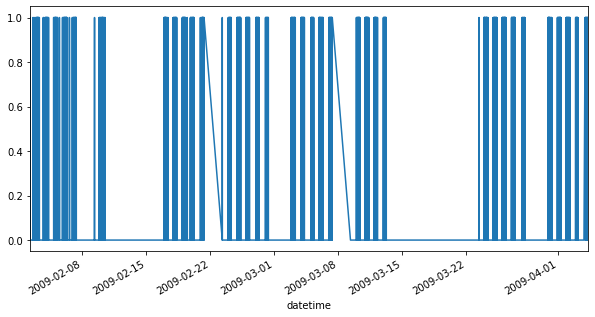

In [23]:
df_categorical_exploded['m35_off'].plot(figsize=(10,5));

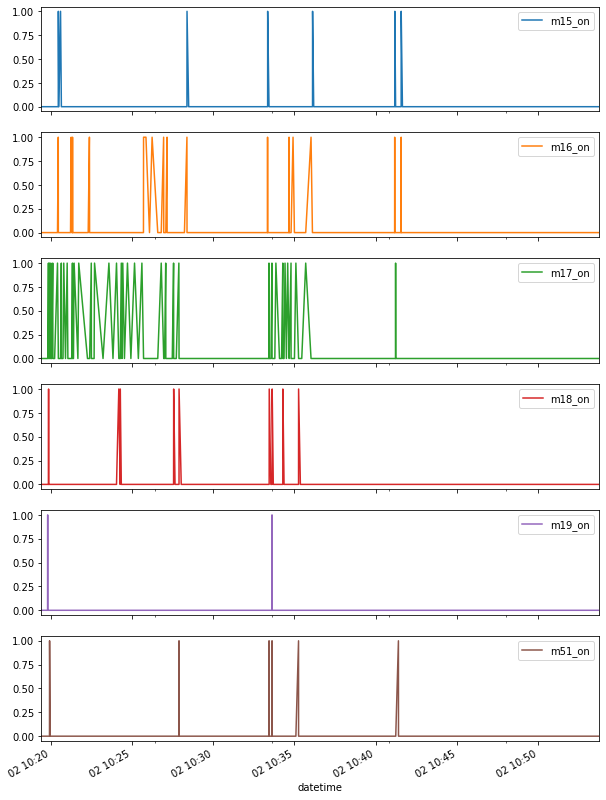

In [24]:
kitchen_columns = ['m{}_on'.format(ii) for ii in (15,16,17,18,19,51)] 

start = datetime(2009, 2, 2, 10) 
end = datetime(2009, 2, 2, 11) 

df_categorical_exploded[(df_categorical_exploded.index > start) & (df_categorical_exploded.index < end)][kitchen_columns].plot(figsize=(10,15), subplots=True); 

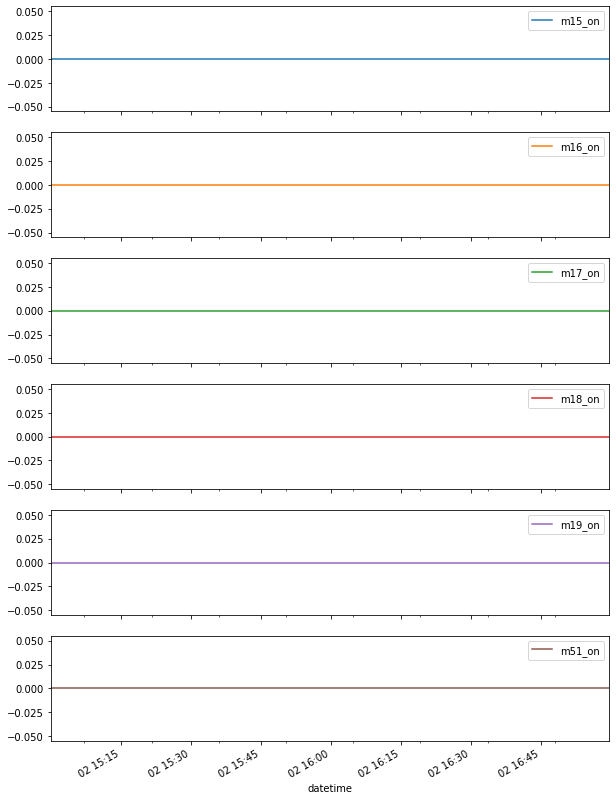

In [25]:
start = datetime(2009, 2, 2, 15) 
end = datetime(2009, 2, 2, 17) 

df_categorical_exploded[(df_categorical_exploded.index > start) & (df_categorical_exploded.index < end)][kitchen_columns].plot(figsize=(10,15), subplots=True); 

# Numeric columns 

We have extracted matrix representation of the categorical data. Now, we will do the same for the numeric data. 

In [26]:
numeric_inds = df.sensor.str.startswith("A")

df_numeric = df.loc[numeric_inds][['sensor', 'value']]

df_numeric.head()

,sensor,value
datetime,,
2009-02-02 07:15:21.408519,AD1-A,2.82231
2009-02-02 07:15:27.529299,AD1-A,2.79926
2009-02-02 07:48:10.647809,AD1-A,2.82754
2009-02-02 07:48:16.658869,AD1-A,2.7977
2009-02-02 07:49:47.980269,AD1-A,2.81895


In [27]:
np.asarray(df_numeric.value)

array(['2.82231', '2.79926', '2.82754', ..., '2.80207', '2.82731',
       '2.80684'], dtype=object)

In [28]:
df_numeric.value.astype(float)

ValueError: could not convert string to float: '0.509695F'

Note, however, that since the value data was obtained from file that it is still in string format. We can convert these `str` data types to floating point data types easily as follows: 

```python 
df_numeric.value.map(float)
```

However, if we do this, we will discover that there is one record that holds a circumspect value (`0.509695F`). This is clearly another mistake in the dataset. We can remove the `F` from the string easily. It is not difficult to make the next bit of code more robust to other data types (eg by applying regular expressions to the strings), but here we will simply slice up until the last character to remove the `F`:

In [29]:
f_inds = df_numeric.value.str.endswith('F')

df_numeric.loc[f_inds, 'value'] = df_numeric.loc[f_inds, 'value'].str[:-1]

df_numeric.loc[f_inds]

,sensor,value
datetime,,
2009-02-19 18:35:43.447570,AD1-B,0.509695


We can now map all data to floating point numbers

In [30]:
df_numeric.value = df_numeric.value.map(float)

There are only three numeric sensor types, as we can see with the `unique` member function:

In [31]:
unique_keys = df_numeric.sensor.unique()

unique_keys

array(['AD1-A', 'AD1-B', 'AD1-C'], dtype=object)

Create some new columns for the three sensors (`AD1-A`, `AD1-B`, and `AD1-C`), and merge with the original data frame

In [32]:
df_numeric = pd.merge(df_numeric[['value']], pd.get_dummies(df_numeric.sensor), left_index=True, right_index=True)

df_numeric.head()

,value,AD1-A,AD1-B,AD1-C
datetime,,,,
2009-02-02 07:15:21.408519,2.82231,1,0,0
2009-02-02 07:15:27.529299,2.79926,1,0,0
2009-02-02 07:48:10.647809,2.82754,1,0,0
2009-02-02 07:48:16.658869,2.79770,1,0,0
2009-02-02 07:49:47.980269,2.81895,1,0,0


In [33]:
for key in unique_keys:
    df_numeric[key] *= df_numeric.value

df_numeric = df_numeric[unique_keys]

# Print a larger sample of the data frame
df_numeric

,AD1-A,AD1-B,AD1-C
datetime,,,
2009-02-02 07:15:21.408519,2.82231,0.0,0.0
2009-02-02 07:15:27.529299,2.79926,0.0,0.0
2009-02-02 07:48:10.647809,2.82754,0.0,0.0
2009-02-02 07:48:16.658869,2.79770,0.0,0.0
2009-02-02 07:49:47.980269,2.81895,0.0,0.0
...,...,...,...
2009-04-03 18:13:07.618079,2.79504,0.0,0.0
2009-04-03 18:13:45.458260,2.82231,0.0,0.0
2009-04-03 18:13:48.585030,2.80207,0.0,0.0


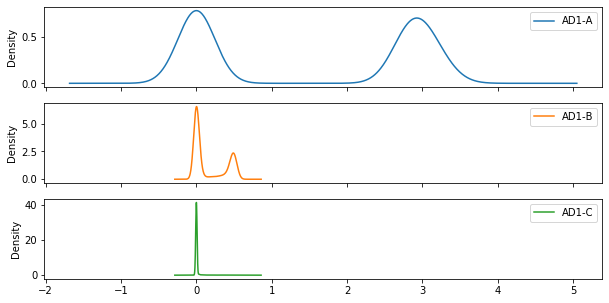

In [34]:
#df_numeric.value.groupby(df_numeric.sensor).plot(kind='kde', legend=True, figsize=(10,5)) 
df_numeric[unique_keys].plot(kind='kde', legend=True, figsize=(10,5), subplots=True); 

# Merging categorical and numeric data together

Since we have two dataframes (one for categorical data and one for numeric data). For any analysis, it would be useful to have these two in a unified data frame. 

First we will remind ourselves what the dataframes look like, and then these will be unified into one format. 

In [35]:
df_categorical_exploded.head()

,d03_close,d03_open,d05_open,d07_close,d07_open,d08_close,d08_open,d09_close,d09_open,d10_close,...,m47_off,m47_on,m48_off,m48_on,m49_off,m49_on,m50_off,m50_on,m51_off,m51_on
datetime,,,,,,,,,,,,,,,,,,,,,
2009-02-02 07:15:16.575809,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2009-02-02 07:15:22.532789,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2009-02-02 07:15:23.345479,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2009-02-02 07:15:28.655329,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2009-02-02 07:15:32.574290,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
df_numeric.head()

,AD1-A,AD1-B,AD1-C
datetime,,,
2009-02-02 07:15:21.408519,2.82231,0.0,0.0
2009-02-02 07:15:27.529299,2.79926,0.0,0.0
2009-02-02 07:48:10.647809,2.82754,0.0,0.0
2009-02-02 07:48:16.658869,2.79770,0.0,0.0
2009-02-02 07:49:47.980269,2.81895,0.0,0.0


We will use the `pandas.merge` function to join the two dataframes. In this case, we must use more of its functionality. We will merge on the `index` of the categorical and numeric dataframes. However, since none of these timestamps are shared (refer to the original data frame) we will do the merge with an `"outer"` join. 

In [37]:
df_joined = pd.merge(
    df_categorical_exploded, 
    df_numeric, 
    left_index=True, 
    right_index=True,
    how='outer'
)

df_joined.head()

,d03_close,d03_open,d05_open,d07_close,d07_open,d08_close,d08_open,d09_close,d09_open,d10_close,...,m48_on,m49_off,m49_on,m50_off,m50_on,m51_off,m51_on,AD1-A,AD1-B,AD1-C
datetime,,,,,,,,,,,,,,,,,,,,,
2009-02-02 07:15:16.575809,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
2009-02-02 07:15:21.408519,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.82231,0.0,0.0
2009-02-02 07:15:22.532789,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
2009-02-02 07:15:23.345479,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
2009-02-02 07:15:27.529299,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.79926,0.0,0.0


Note, that in merging the dataframes, we now have a time-ordered dataframe. This is one of the advantages of using `datetime`s as the index type in dataframes since `pandas` will understand precisely how to merge the two datasets. 

# Annotations

So far we have extracted the categorical and the numeric data from the dataframe. The annotations/labels have not yet been considered. This section will focus on these data. 

Since this part of the notebook will focus only on the annotations, the annotation dataframe will slice these columns exclusively. 

Finally, because the annotations have `begin` and `end` times, we will need to fill in the time between begin and end with 1's. The ideal output therefore will be that we produce a matrix. Each column of the matrix will correspond to a particular activity. The duration of the activity is captured with a series of 1's. This is similar to the techniques we used to create the categorical dataframe, however, in that we only recorded that a sensor turned on and off, and did not track its continuous state. 

In [38]:
annotation_inds = pd.notnull(df.annotation)

df_annotation = df.loc[annotation_inds][['annotation', 'state']]

# There are some duplicated indices. Remove with
df_annotation = df_annotation.groupby(level=0).first()

df_annotation.head()

,annotation,state
datetime,,
2009-02-02 07:15:16.575809,R1_Bed_to_Toilet,begin
2009-02-02 07:21:03.792759,R1_Bed_to_Toilet,end
2009-02-02 07:21:04.014729,R1_Personal_Hygiene,begin
2009-02-02 07:38:33.946559,R1_Personal_Hygiene,end
2009-02-02 07:44:12.597919,R2_Bed_to_Toilet,begin


It's important to ensure that the expected format of the data is consistent in this dataset. This means that there should be 

One way to do this is to group by the annotation label and to print some statistics about the data. 

In [39]:
for annotation, group in df_annotation.groupby('annotation'): 
    counts = group.state.value_counts()
    
    if counts.begin == counts.end: 
        print('             {}: equal counts ({}, {})'.format(
            annotation, 
            counts.begin, 
            counts.end
        ))
        
    else:
        print(' *** WARNING {}: inconsistent annotation counts with {} begin and {} end'.format(
            annotation, 
            counts.begin, 
            counts.end
        ))

             Clean: equal counts (2, 2)
             Meal_Preparation: equal counts (118, 118)
             R1_Bed_to_Toilet: equal counts (34, 34)
 *** WARNING R1_Personal_Hygiene: inconsistent annotation counts with 44 begin and 45 end
             R1_Sleep: equal counts (35, 35)
 *** WARNING R1_Work: inconsistent annotation counts with 59 begin and 60 end
             R2_Bed_to_Toilet: equal counts (39, 39)
 *** WARNING R2_Personal_Hygiene: inconsistent annotation counts with 38 begin and 39 end
             R2_Sleep: equal counts (34, 34)
             R2_Work: equal counts (44, 44)
             Study: equal counts (9, 9)
             Wash_Bathtub: equal counts (1, 1)
             Watch_TV: equal counts (31, 31)


We can see here that two activities have inconsistent numbers of `begin` and `end` statements for the activities. Interestingly, they both have more `end` conditions than `begin` conditions. In some sense, this is a less critical bug than having more `begin` statements. 

In order to deal with this, we will first look at the affected rows: 

In [40]:
df_annotation.loc[df_annotation.annotation == 'R1_Work']

,annotation,state
datetime,,
2009-02-02 14:29:03.195450,R1_Work,begin
2009-02-02 17:37:22.211110,R1_Work,end
2009-02-02 19:00:18.038599,R1_Work,begin
2009-02-02 19:30:06.534640,R1_Work,end
2009-02-03 17:57:46.718869,R1_Work,begin
...,...,...
2009-04-02 17:51:11.816370,R1_Work,begin
2009-04-02 19:59:07.909409,R1_Work,end
2009-04-02 22:28:09.071290,R1_Work,end


Querying consecutive annotations, we can print the pair of annotations that have 

In [41]:
def filter_annotations(anns):
    left = iter(anns.index[:-1])
    right = iter(anns.index[1:])

    inds = []
    for ii, (ll, rr) in enumerate(zip(left, right)): 
        try:
            l = anns.loc[ll]
            r = anns.loc[rr]

            if l.state == 'begin' and r.state == 'end': 
                inds.extend([ll, rr])
                
        except ValueError:
            print(ii) 
            print(l)
            print()
            print(r)
            print()
            print() 
            
            asdf

    return anns.loc[inds, :]
        

dfs = []
for annotation, group in df_annotation.groupby('annotation'): 
    print('{:>30} - {}'.format(annotation, group.size))
    dfs.append(filter_annotations(group))


                         Clean - 8
              Meal_Preparation - 472
              R1_Bed_to_Toilet - 136
           R1_Personal_Hygiene - 178
                      R1_Sleep - 140
                       R1_Work - 238
              R2_Bed_to_Toilet - 156
           R2_Personal_Hygiene - 154
                      R2_Sleep - 136
                       R2_Work - 176
                         Study - 36
                  Wash_Bathtub - 4
                      Watch_TV - 124


Create the output dataframe

In [42]:
df_annotation_exploded = pd.get_dummies(df_annotation.annotation)

df_annotation_exploded.head(50)

,Clean,Meal_Preparation,R1_Bed_to_Toilet,R1_Personal_Hygiene,R1_Sleep,R1_Work,R2_Bed_to_Toilet,R2_Personal_Hygiene,R2_Sleep,R2_Work,Study,Wash_Bathtub,Watch_TV
datetime,,,,,,,,,,,,,
2009-02-02 07:15:16.575809,0,0,1,0,0,0,0,0,0,0,0,0,0
2009-02-02 07:21:03.792759,0,0,1,0,0,0,0,0,0,0,0,0,0
2009-02-02 07:21:04.014729,0,0,0,1,0,0,0,0,0,0,0,0,0
2009-02-02 07:38:33.946559,0,0,0,1,0,0,0,0,0,0,0,0,0
2009-02-02 07:44:12.597919,0,0,0,0,0,0,1,0,0,0,0,0,0
2009-02-02 07:46:55.137900,0,0,0,0,0,0,1,0,0,0,0,0,0
2009-02-02 07:47:19.239909,0,1,0,0,0,0,0,0,0,0,0,0,0
2009-02-02 07:55:23.862210,0,1,0,0,0,0,0,0,0,0,0,0,0
2009-02-02 10:19:49.541500,0,1,0,0,0,0,0,0,0,0,0,0,0


In [43]:
paired = pd.concat(dfs)

left = paired.index[:-1:2]
right = paired.index[1::2]

print(df_annotation_exploded.mean())
for ll, rr in zip(left, right): 
    l = paired.loc[ll]
    r = paired.loc[rr]
    
    assert l.annotation == r.annotation
    
    annotation = l.annotation
    begin = l.name
    end = r.name
    
    # Another advantage of using datetime index: can slice with time ranges
    df_annotation_exploded.loc[begin:end, annotation] = 1

Clean                  0.004086
Meal_Preparation       0.241062
R1_Bed_to_Toilet       0.069459
R1_Personal_Hygiene    0.090909
R1_Sleep               0.071502
R1_Work                0.121553
R2_Bed_to_Toilet       0.079673
R2_Personal_Hygiene    0.078652
R2_Sleep               0.069459
R2_Work                0.089888
Study                  0.018386
Wash_Bathtub           0.002043
Watch_TV               0.063330
dtype: float64


In [44]:
df_annotation_exploded.head(50)

,Clean,Meal_Preparation,R1_Bed_to_Toilet,R1_Personal_Hygiene,R1_Sleep,R1_Work,R2_Bed_to_Toilet,R2_Personal_Hygiene,R2_Sleep,R2_Work,Study,Wash_Bathtub,Watch_TV
datetime,,,,,,,,,,,,,
2009-02-02 07:15:16.575809,0,0,1,0,0,0,0,0,0,0,0,0,0
2009-02-02 07:21:03.792759,0,0,1,0,0,0,0,0,0,0,0,0,0
2009-02-02 07:21:04.014729,0,0,0,1,0,0,0,0,0,0,0,0,0
2009-02-02 07:38:33.946559,0,0,0,1,0,0,0,0,0,0,0,0,0
2009-02-02 07:44:12.597919,0,0,0,0,0,0,1,0,0,0,0,0,0
2009-02-02 07:46:55.137900,0,0,0,0,0,0,1,0,0,0,0,0,0
2009-02-02 07:47:19.239909,0,1,0,0,0,0,0,0,0,0,0,0,0
2009-02-02 07:55:23.862210,0,1,0,0,0,0,0,0,0,0,0,0,0
2009-02-02 10:19:49.541500,0,1,0,0,0,0,0,0,0,0,0,0,0


# Merging the full dataset

In [45]:
dataset = pd.merge(
    df_joined, 
    df_annotation_exploded, 
    left_index=True, 
    right_index=True, 
    how='outer'
)

data_cols = df_joined.columns
annotation_cols = df_annotation_exploded.columns

In [46]:
dataset[data_cols] = dataset[data_cols].fillna(0)
dataset[annotation_cols] = dataset[annotation_cols].ffill()

dataset.head()

,d03_close,d03_open,d05_open,d07_close,d07_open,d08_close,d08_open,d09_close,d09_open,d10_close,...,R1_Personal_Hygiene,R1_Sleep,R1_Work,R2_Bed_to_Toilet,R2_Personal_Hygiene,R2_Sleep,R2_Work,Study,Wash_Bathtub,Watch_TV
datetime,,,,,,,,,,,,,,,,,,,,,
2009-02-02 07:15:16.575809,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2009-02-02 07:15:21.408519,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2009-02-02 07:15:22.532789,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2009-02-02 07:15:23.345479,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2009-02-02 07:15:27.529299,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
dataset[data_cols].head()

,d03_close,d03_open,d05_open,d07_close,d07_open,d08_close,d08_open,d09_close,d09_open,d10_close,...,m48_on,m49_off,m49_on,m50_off,m50_on,m51_off,m51_on,AD1-A,AD1-B,AD1-C
datetime,,,,,,,,,,,,,,,,,,,,,
2009-02-02 07:15:16.575809,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
2009-02-02 07:15:21.408519,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.82231,0.0,0.0
2009-02-02 07:15:22.532789,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
2009-02-02 07:15:23.345479,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
2009-02-02 07:15:27.529299,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.79926,0.0,0.0


In [48]:
dataset[annotation_cols].head()

,Clean,Meal_Preparation,R1_Bed_to_Toilet,R1_Personal_Hygiene,R1_Sleep,R1_Work,R2_Bed_to_Toilet,R2_Personal_Hygiene,R2_Sleep,R2_Work,Study,Wash_Bathtub,Watch_TV
datetime,,,,,,,,,,,,,
2009-02-02 07:15:16.575809,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2009-02-02 07:15:21.408519,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2009-02-02 07:15:22.532789,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2009-02-02 07:15:23.345479,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2009-02-02 07:15:27.529299,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
dataset.loc[dataset.Meal_Preparation == 1][kitchen_columns + ['AD1-A']].head()

,m15_on,m16_on,m17_on,m18_on,m19_on,m51_on,AD1-A
datetime,,,,,,,
2009-02-02 07:47:19.239909,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2009-02-02 07:47:20.857180,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2009-02-02 07:47:21.147439,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2009-02-02 07:47:21.426199,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2009-02-02 07:47:24.357180,0.0,0.0,0.0,0.0,0.0,0.0,0.0
